# Calculate Price Elasticity Scores: Hex x Timebucket

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore')

import ast
import datetime
import glob
import json
import uuid
import time

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 50)

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from tqdm.notebook import tqdm
tqdm.pandas()

from h3 import h3
from sklearn.linear_model import LinearRegression

In [2]:
%%html
<style>
.dataframe td {
    white-space: nowrap;
}
</style>

In [3]:

CONFIG_CITY = 'Bangalore'
CONFIG_SERVICE_LEVEL = 'Link'
CONFIG_EXPERIMENT_DATE = datetime.date(2022, 12, 1)
OUTPUT_DIRECTORY = '/tmp/price_elasticity/'


In [4]:
"""
from pyhive import presto
presto_connection = presto.connect(
    host='presto-gateway.serving.data.production.internal',
    port=80,
    protocol='http',
    catalog='hive',
    username='manoj.ravirajan@rapido.bike'
)
"""

"\nfrom pyhive import presto\npresto_connection = presto.connect(\n    host='presto-gateway.serving.data.production.internal',\n    port=80,\n    protocol='http',\n    catalog='hive',\n    username='manoj.ravirajan@rapido.bike'\n)\n"

In [5]:
'''
query = """
SELECT
    icr.yyyymmdd,
    CASE
        WHEN icr.quarter_hour >= '0000' AND icr.quarter_hour < '0800' THEN 'rest_morning'
        WHEN icr.quarter_hour >= '0800' AND icr.quarter_hour < '1200' THEN 'morning_peak'
        WHEN icr.quarter_hour >= '1200' AND icr.quarter_hour < '1700' THEN 'afternoon'
        WHEN icr.quarter_hour >= '1700' AND icr.quarter_hour < '2200' THEN 'evening_peak'
        WHEN icr.quarter_hour >= '2200' AND icr.quarter_hour < '2400' THEN 'rest_evening'
    END timebucket,
    icr.hour,
    icr.quarter_hour,
    icr.city,
    icr.computed_pickup_cluster cluster,
    icr.computed_pick_hex8 hex,
    icr.fare_estimate_id,
    icr.customer_id,
    icr.dynamic_surge_factor_type surge_type,
    icr.dynamic_surge_factor surge_percentage,  -- For the price elasticity experiments, surge is as a percentage.
    icr.dynamic_surge_amount surge_amount,
    icr.rate_card_amount,
    fee.sub_total,
    ols.order_id,
    ols.order_status
FROM
        experiments.iprice_cleaned_responses_v2 icr
        JOIN pricing_internal.fare_estimates_enriched_v1 fee ON fee.yyyymmdd = '{yyyymmdd}'
            AND fee.service_name = '{service_level}'
            AND fee.fare_estimate_id = icr.fare_estimate_id
        LEFT JOIN hive.orders.order_logs_snapshot ols ON ols.yyyymmdd = '{yyyymmdd}'
            AND ols.estimate_id = icr.fare_estimate_id
            AND ols.service_obj_service_name = '{service_level}'
WHERE
        icr.yyyymmdd = '{yyyymmdd}'
        AND icr.city = '{city}'
        AND icr.service_level = '{service_level}'
        AND icr.surge_strategy = 'experiment'
""".format(
    yyyymmdd = CONFIG_EXPERIMENT_DATE.strftime('%Y%m%d'),
    service_level = CONFIG_SERVICE_LEVEL,
    city = CONFIG_CITY,
)
fare_estimates_raw = pd.read_sql_query(query, presto_connection)
'''

'\nquery = """\nSELECT\n    icr.yyyymmdd,\n    CASE\n        WHEN icr.quarter_hour >= \'0000\' AND icr.quarter_hour < \'0800\' THEN \'rest_morning\'\n        WHEN icr.quarter_hour >= \'0800\' AND icr.quarter_hour < \'1200\' THEN \'morning_peak\'\n        WHEN icr.quarter_hour >= \'1200\' AND icr.quarter_hour < \'1700\' THEN \'afternoon\'\n        WHEN icr.quarter_hour >= \'1700\' AND icr.quarter_hour < \'2200\' THEN \'evening_peak\'\n        WHEN icr.quarter_hour >= \'2200\' AND icr.quarter_hour < \'2400\' THEN \'rest_evening\'\n    END timebucket,\n    icr.hour,\n    icr.quarter_hour,\n    icr.city,\n    icr.computed_pickup_cluster cluster,\n    icr.computed_pick_hex8 hex,\n    icr.fare_estimate_id,\n    icr.customer_id,\n    icr.dynamic_surge_factor_type surge_type,\n    icr.dynamic_surge_factor surge_percentage,  -- For the price elasticity experiments, surge is as a percentage.\n    icr.dynamic_surge_amount surge_amount,\n    icr.rate_card_amount,\n    fee.sub_total,\n    ols.order

## Step 1
### Experiment data (Bangalore | Link)

In [6]:
raw_fare_estimates_raw = pd.read_csv('/Users/rapido/local-datasets/affluence/raw/fare_estimates_raw.csv')
raw_fare_estimates_raw.shape

(1109389, 16)

In [7]:
fare_estimates_raw = raw_fare_estimates_raw.copy(deep=True)
print(fare_estimates_raw.shape)
fare_estimates_raw.head(2)

(1109389, 16)


,yyyymmdd,timebucket,hour,quarter_hour,city,cluster,hex,fare_estimate_id,customer_id,surge_type,surge_percentage,surge_amount,rate_card_amount,sub_total,order_id,order_status
0,20221201,morning_peak,10,1045,Bangalore,Nagavara,8861892cc7fffff,638839d698cfdf63a87bb384,62e1ee8dcb615716c05c4112,NaN,-999.0,0.0,39.35,40.0,638839d94b964d1189f2537d,dropped
1,20221201,morning_peak,11,1115,Bangalore,Bommanahali,8861892439fffff,63883f7d98cfdf75d27bc7ff,5afc010b5737116ecbc10274,NaN,-999.0,0.0,26.78,27.0,63883f9ed1f95e048705215e,dropped


In [8]:
fare_estimates = fare_estimates_raw.copy(deep=True)

# Convert columns from string to float.
columns = ['surge_percentage', 'surge_amount', 'rate_card_amount']
fare_estimates[columns] = fare_estimates[columns].astype('float')

def calculate_is_dropped_order(row):
    if row['order_status'] == 'dropped':
        return row['order_id']
fare_estimates['dropped_order_id'] = fare_estimates.apply(calculate_is_dropped_order, axis=1)

# Replace dynamic surge factor in the Control group.
fare_estimates['surge_percentage'].replace(-999, 0.0, inplace=True)

print(fare_estimates.shape)
fare_estimates.head(1)

(1109389, 17)


,yyyymmdd,timebucket,hour,quarter_hour,city,cluster,hex,fare_estimate_id,customer_id,surge_type,surge_percentage,surge_amount,rate_card_amount,sub_total,order_id,order_status,dropped_order_id
0,20221201,morning_peak,10,1045,Bangalore,Nagavara,8861892cc7fffff,638839d698cfdf63a87bb384,62e1ee8dcb615716c05c4112,NaN,0.0,0.0,39.35,40.0,638839d94b964d1189f2537d,dropped,638839d94b964d1189f2537d


## Step 1.1
### Validate the experiment setup by aggregating fare estimates by surge percentage.

In [9]:
# Validate the experiment setup by aggregating fare estimates by surge percentage.
counts = fare_estimates \
    .groupby('surge_percentage') \
    .agg(
        fare_estimates=pd.NamedAgg('fare_estimate_id', 'nunique'),
        gross_orders=pd.NamedAgg('order_id', 'nunique'),
        net_orders=pd.NamedAgg('dropped_order_id', 'nunique'),
    ) \
    .reset_index()

counts['fare_percentage'] = (100 * counts['fare_estimates'] / counts['fare_estimates'].sum()).round()
counts['gross_percentage'] = (100 * counts['gross_orders'] / counts['gross_orders'].sum()).round()
counts['net_percentage'] = (100 * counts['net_orders'] / counts['net_orders'].sum()).round()
counts

,surge_percentage,fare_estimates,gross_orders,net_orders,fare_percentage,gross_percentage,net_percentage
0,0.0,530936,69579,33168,50.0,59.0,59.0
1,10.0,104674,12636,6121,10.0,11.0,11.0
2,20.0,103392,10777,5275,10.0,9.0,9.0
3,30.0,105497,10095,4796,10.0,9.0,8.0
4,40.0,103775,8380,3948,10.0,7.0,7.0
5,50.0,103197,7226,3342,10.0,6.0,6.0


## Step 2
### Calculate price_elasticity & price_elasticity_label

In [10]:
def calculate_price_elasticity(row):

    try:

        delta_fe2rr = (row['fe2rr'] - row['previous_fe2rr']) / ((row['fe2rr'] + row['previous_fe2rr']) / 2)
        delta_surge_percentage = (row['surge_percentage'] - row['previous_surge_percentage']) / ((row['surge_percentage'] + row['previous_surge_percentage']) / 2)

        return round(delta_fe2rr / delta_surge_percentage, 2)
        
    except ZeroDivisionError as e:
        pass

calculate_price_elasticity({'fe2rr': 14, 'previous_fe2rr': 10, 'surge_percentage': 20, 'previous_surge_percentage': 30})

-0.83

In [11]:
def calculate_price_elasticity_label(ep):
    """Calculate the ep label based on the ep value."""

    # Remove the negative sign when present.
    ep = abs(ep)

    if pd.isna(ep):  return 'undefined'
    if ep == 0.0:    return 'perfectly_inelastic'
    elif ep == 1.0:  return 'unitary_elastic'
    elif ep > 1.0:   return 'highly_elastic'
    elif ep < 1.0:   return 'less_elastic'
    else:            return 'error'

calculate_price_elasticity_label(0.8)

'less_elastic'

In [12]:
# Get a sample pickup cluster for looking at examples.
sample = fare_estimates \
    .groupby(['cluster', 'hex', 'timebucket']) \
    .agg(fare_estimates=pd.NamedAgg('fare_estimate_id', 'nunique')) \
    .reset_index() \
    .sort_values(ascending=False, by='fare_estimates').iloc[0]

sample

cluster           St Johns Signal
hex               88618925c7fffff
timebucket           evening_peak
fare_estimates               7227
Name: 4925, dtype: object

## Step 2.1

### Hex x Timebucket

In [13]:
# Aggregate by geo-temporal slice of hex x timebucket.
dataset = fare_estimates \
    .groupby(['yyyymmdd', 'timebucket', 'city', 'cluster', 'hex', 'surge_percentage']) \
    .agg(
        fare_estimates=pd.NamedAgg('fare_estimate_id', 'nunique'),
        gross_orders=pd.NamedAgg('order_id', 'nunique')
    ) \
    .reset_index()    

dataset['fe2rr'] = (100 * dataset['gross_orders'] / dataset['fare_estimates']).round(2)

print(dataset.shape)
dataset[
    (dataset['cluster'] == sample['cluster'])
    & (dataset['hex'] == sample['hex'])
    & (dataset['timebucket'] == sample['timebucket'])
].sort_values(by='surge_percentage')

(26461, 9)


,yyyymmdd,timebucket,city,cluster,hex,surge_percentage,fare_estimates,gross_orders,fe2rr
11165,20221201,evening_peak,Bangalore,St Johns Signal,88618925c7fffff,0.0,3736,391,10.47
11166,20221201,evening_peak,Bangalore,St Johns Signal,88618925c7fffff,10.0,719,70,9.74
11167,20221201,evening_peak,Bangalore,St Johns Signal,88618925c7fffff,20.0,729,45,6.17
11168,20221201,evening_peak,Bangalore,St Johns Signal,88618925c7fffff,30.0,653,56,8.58
11169,20221201,evening_peak,Bangalore,St Johns Signal,88618925c7fffff,40.0,802,73,9.10
11170,20221201,evening_peak,Bangalore,St Johns Signal,88618925c7fffff,50.0,588,25,4.25


In [14]:
# Shift surge percentage and FE2RR for a geo-temporal slice.
dataset.sort_values(by=['yyyymmdd', 'timebucket', 'city', 'cluster', 'hex', 'surge_percentage'], inplace=True)
dataset['previous_surge_percentage'] = dataset.groupby(['yyyymmdd', 'timebucket', 'city', 'cluster', 'hex'])['surge_percentage'].shift()
dataset['previous_fe2rr'] = dataset.groupby(['yyyymmdd', 'timebucket', 'city', 'cluster', 'hex'])['fe2rr'].shift()

print(dataset.shape)
dataset[
    (dataset['cluster'] == sample['cluster'])
    & (dataset['hex'] == sample['hex'])
    & (dataset['timebucket'] == sample['timebucket'])
].sort_values(by='surge_percentage')

(26461, 11)


,yyyymmdd,timebucket,city,cluster,hex,surge_percentage,fare_estimates,gross_orders,fe2rr,previous_surge_percentage,previous_fe2rr
11165,20221201,evening_peak,Bangalore,St Johns Signal,88618925c7fffff,0.0,3736,391,10.47,NaN,NaN
11166,20221201,evening_peak,Bangalore,St Johns Signal,88618925c7fffff,10.0,719,70,9.74,0.0,10.47
11167,20221201,evening_peak,Bangalore,St Johns Signal,88618925c7fffff,20.0,729,45,6.17,10.0,9.74
11168,20221201,evening_peak,Bangalore,St Johns Signal,88618925c7fffff,30.0,653,56,8.58,20.0,6.17
11169,20221201,evening_peak,Bangalore,St Johns Signal,88618925c7fffff,40.0,802,73,9.10,30.0,8.58
11170,20221201,evening_peak,Bangalore,St Johns Signal,88618925c7fffff,50.0,588,25,4.25,40.0,9.10


In [15]:
# Calculate price elasticity and price elasticity labels.
dataset['price_elasticity'] = dataset.apply(calculate_price_elasticity, axis=1)
dataset['price_elasticity_label'] = dataset['price_elasticity'].apply(calculate_price_elasticity_label)

dataset.drop(columns=['previous_surge_percentage', 'previous_fe2rr'], inplace=True)

print(dataset.shape)
dataset[
    (dataset['cluster'] == sample['cluster'])
    & (dataset['hex'] == sample['hex'])
    & (dataset['timebucket'] == sample['timebucket'])
].sort_values(by='surge_percentage').reset_index(drop=True)

(26461, 11)


,yyyymmdd,timebucket,city,cluster,hex,surge_percentage,fare_estimates,gross_orders,fe2rr,price_elasticity,price_elasticity_label
0,20221201,evening_peak,Bangalore,St Johns Signal,88618925c7fffff,0.0,3736,391,10.47,NaN,undefined
1,20221201,evening_peak,Bangalore,St Johns Signal,88618925c7fffff,10.0,719,70,9.74,-0.04,less_elastic
2,20221201,evening_peak,Bangalore,St Johns Signal,88618925c7fffff,20.0,729,45,6.17,-0.67,less_elastic
3,20221201,evening_peak,Bangalore,St Johns Signal,88618925c7fffff,30.0,653,56,8.58,0.82,less_elastic
4,20221201,evening_peak,Bangalore,St Johns Signal,88618925c7fffff,40.0,802,73,9.10,0.21,less_elastic
5,20221201,evening_peak,Bangalore,St Johns Signal,88618925c7fffff,50.0,588,25,4.25,-3.27,highly_elastic


In [16]:
# Distribution of geo-temporal slices by their elasticity labels.
counts = dataset \
    .groupby(['price_elasticity_label']) \
    .agg(fare_estimates=pd.NamedAgg('fare_estimates', 'sum')) \
    .sort_values(by=['fare_estimates'], ascending=False) \
    .reset_index()

counts['fare_percentage'] = (100 * counts['fare_estimates'] / counts['fare_estimates'].sum()).round(1)
counts

,price_elasticity_label,fare_estimates,fare_percentage
0,undefined,554075,52.8
1,less_elastic,248238,23.6
2,highly_elastic,230161,21.9
3,unitary_elastic,13064,1.2
4,perfectly_inelastic,4126,0.4


In [17]:
counts.fare_estimates.sum()

1049664

In [18]:
counts = dataset \
    .groupby(['yyyymmdd', 'timebucket', 'city', 'cluster', 'hex']) \
    .agg({'fare_estimates': 'sum'}) \
    .reset_index() \
    .sort_values(by='fare_estimates', ascending=False) \
    .reset_index(drop=True)

sample = counts.iloc[0]
sample

yyyymmdd                 20221201
timebucket           evening_peak
city                    Bangalore
cluster           St Johns Signal
hex               88618925c7fffff
fare_estimates               7227
Name: 0, dtype: object

In [19]:
# sample = {'cluster': 'Shamshabad 4', 'timebucket': 'evening_peak', 'city': 'Hyderabad'}

In [20]:
columns = ['yyyymmdd', 'timebucket', 'city', 'cluster', 'hex', 'surge_percentage', 'fare_estimates', 'gross_orders', 'fe2rr', 'price_elasticity', 'price_elasticity_label']
dataset_subset = dataset[
    (dataset['cluster'] == sample['cluster'])
    & (dataset['hex'] == sample['hex'])
    & (dataset['timebucket'] == sample['timebucket'])
][columns].reset_index(drop=True).copy(deep=True)
dataset_subset

,yyyymmdd,timebucket,city,cluster,hex,surge_percentage,fare_estimates,gross_orders,fe2rr,price_elasticity,price_elasticity_label
0,20221201,evening_peak,Bangalore,St Johns Signal,88618925c7fffff,0.0,3736,391,10.47,NaN,undefined
1,20221201,evening_peak,Bangalore,St Johns Signal,88618925c7fffff,10.0,719,70,9.74,-0.04,less_elastic
2,20221201,evening_peak,Bangalore,St Johns Signal,88618925c7fffff,20.0,729,45,6.17,-0.67,less_elastic
3,20221201,evening_peak,Bangalore,St Johns Signal,88618925c7fffff,30.0,653,56,8.58,0.82,less_elastic
4,20221201,evening_peak,Bangalore,St Johns Signal,88618925c7fffff,40.0,802,73,9.10,0.21,less_elastic
5,20221201,evening_peak,Bangalore,St Johns Signal,88618925c7fffff,50.0,588,25,4.25,-3.27,highly_elastic


In [21]:
model = LinearRegression()
model.fit(dataset_subset[['surge_percentage']], dataset_subset['fe2rr'])
slope, intercept = round(model.coef_[0], 3), round(model.intercept_, 3)
slope, intercept

(-0.087, 10.238)

In [22]:
score = round(model.score(dataset_subset[['surge_percentage']], dataset_subset['fe2rr']), 3)
score

0.477

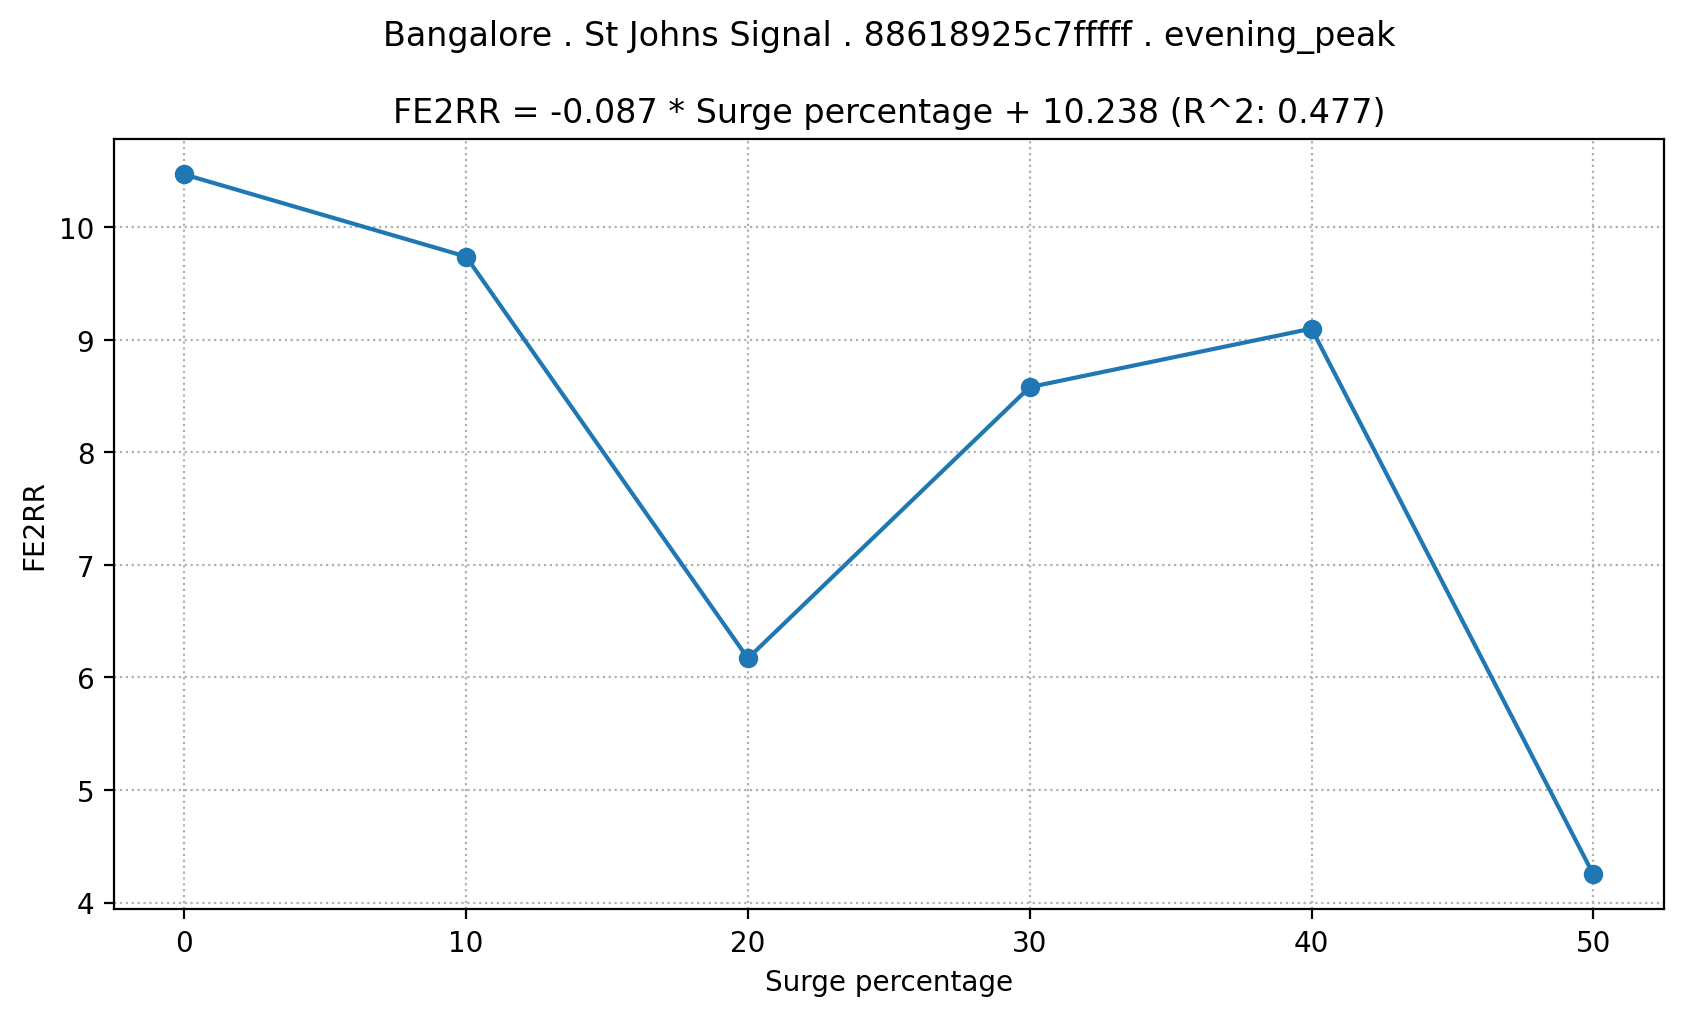

In [23]:
ax = dataset_subset.plot(x='surge_percentage', y='fe2rr', figsize=(10, 5), marker='o')

plt.grid(linestyle='dotted')
ax.legend().remove()
ax.set_xlabel('Surge percentage')
ax.set_ylabel('FE2RR')
ax.set_title('{} . {} . {} . {}\n\nFE2RR = {} * Surge percentage + {} (R^2: {})'.format(
    sample['city'], sample['cluster'], sample['hex'], sample['timebucket'],
    slope, intercept,
    score
));

## Step 2.2
### Geo-temporal slices that have multiple price elasticity labels.

In [24]:
# Geo-temporal slices that have multiple price elasticity labels.
dataset.groupby(['yyyymmdd', 'timebucket', 'city', 'cluster', 'hex']).agg({'price_elasticity_label': 'nunique'}).sort_values(ascending=False, by='price_elasticity_label').head(5)

price_elasticity_label
yyyymmdd timebucket   city      cluster           hex                                    
20221201 rest_evening Bangalore Kathriguppe       8860145a41fffff                       5
         evening_peak Bangalore Chikkabanavara    88601459e7fffff                       5
         afternoon    Bangalore Electronic City   8861892605fffff                       5
         evening_peak Bangalore Sarjapur Road     88618920c3fffff                       5
                                Basaveshwar Nagar 8860145861fffff                       5

In [25]:
# What is the volume of fare estimates and gross orders in the geotemporal slices?
dataset[['fare_estimates', 'gross_orders']].describe().round(1)

,fare_estimates,gross_orders
count,26461.0,26461.0
mean,39.7,4.5
std,98.3,13.2
min,1.0,0.0
25%,4.0,0.0
50%,13.0,1.0
75%,36.0,4.0
max,3736.0,391.0


## Step 3
### Calculate one elasticity label for the entire geo-temporal slice.

In [26]:
# Calculate one elasticity label for the entire geo-temporal slice.
counts = dataset \
    .groupby(['yyyymmdd', 'timebucket', 'city', 'cluster', 'hex']) \
    .agg({'fare_estimates': 'sum'}) \
    .reset_index() \
    .sort_values(by='fare_estimates', ascending=False) \
    .reset_index(drop=True)

In [27]:
def calculate_geotemporal_price_elasticity(rows):

    old = rows.iloc[0]
    new = rows.iloc[-1]

    try:
        price_delta = (new['surge_percentage'] - old['surge_percentage']) / ((new['surge_percentage'] + old['surge_percentage']) / 2)
        quantity_delta = (new['fe2rr'] - old['fe2rr']) / ((new['fe2rr'] + old['fe2rr']) / 2)

        return round(quantity_delta / price_delta, 2)
    except ZeroDivisionError as e:
        return

In [28]:
dataset_subset = dataset[
    (dataset['yyyymmdd'] == sample['yyyymmdd'])
    & (dataset['timebucket'] == sample['timebucket'])
    & (dataset['city'] == sample['city'])
    & (dataset['cluster'] == sample['cluster'])
    & (dataset['hex'] == sample['hex'])
][columns].reset_index(drop=True).copy(deep=True)

print(calculate_geotemporal_price_elasticity(dataset_subset))

dataset_subset

-0.42


,yyyymmdd,timebucket,city,cluster,hex,surge_percentage,fare_estimates,gross_orders,fe2rr,price_elasticity,price_elasticity_label
0,20221201,evening_peak,Bangalore,St Johns Signal,88618925c7fffff,0.0,3736,391,10.47,NaN,undefined
1,20221201,evening_peak,Bangalore,St Johns Signal,88618925c7fffff,10.0,719,70,9.74,-0.04,less_elastic
2,20221201,evening_peak,Bangalore,St Johns Signal,88618925c7fffff,20.0,729,45,6.17,-0.67,less_elastic
3,20221201,evening_peak,Bangalore,St Johns Signal,88618925c7fffff,30.0,653,56,8.58,0.82,less_elastic
4,20221201,evening_peak,Bangalore,St Johns Signal,88618925c7fffff,40.0,802,73,9.10,0.21,less_elastic
5,20221201,evening_peak,Bangalore,St Johns Signal,88618925c7fffff,50.0,588,25,4.25,-3.27,highly_elastic


In [29]:
results = []
for i, row in counts.drop(columns='fare_estimates').iterrows():

    columns = ['yyyymmdd', 'timebucket', 'city', 'cluster', 'surge_percentage', 'fare_estimates', 'gross_orders', 'fe2rr', 'price_elasticity', 'price_elasticity_label']
    dataset_subset = dataset[
        (dataset['yyyymmdd'] == row['yyyymmdd'])
        & (dataset['timebucket'] == row['timebucket'])
        & (dataset['city'] == row['city'])
        & (dataset['cluster'] == row['cluster'])
        & (dataset['hex'] == row['hex'])
    ][columns].reset_index(drop=True).copy(deep=True).sort_values(by='surge_percentage')

    result = row.to_dict()
    result['price_elasticity'] = calculate_geotemporal_price_elasticity(dataset_subset)
    result['price_elasticity_label'] = calculate_price_elasticity_label(result['price_elasticity'])

    model = LinearRegression()
    model.fit(dataset_subset[['surge_percentage']], dataset_subset['fe2rr'])
    result['price_elasticity_curve_slope'] = round(model.coef_[0], 3)
    result['price_elasticity_curve_intercept'] = round(model.intercept_, 3)

    result['price_elasticity_curve_confidence'] = round(model.score(dataset_subset[['surge_percentage']], dataset_subset['fe2rr']), 3)
    if result['price_elasticity_curve_slope'] == 0 and result['price_elasticity_curve_confidence'] == 0:
        result['price_elasticity_curve_confidence'] = 0
    elif pd.isna(result['price_elasticity_curve_confidence']):
        result['price_elasticity_curve_confidence'] = 0

    result['surge_percentages'] = dataset_subset['surge_percentage'].agg(lambda x: json.dumps(list(x.values)))
    result['fare_estimates'] = dataset_subset['fare_estimates'].agg(lambda x: json.dumps([int(item) for item in list(x.values)]))
    result['gross_orders'] = dataset_subset['gross_orders'].agg(lambda x: json.dumps([int(item) for item in list(x.values)]))
    result['fe2rrs'] = dataset_subset['fe2rr'].agg(lambda x: json.dumps(list(x.values)))
    result['price_elasticities'] = dataset_subset['price_elasticity'].agg(lambda x: json.dumps(list(x.values)))
    result['price_elasticity_labels'] = dataset_subset['price_elasticity_label'].agg(lambda x: json.dumps(list(x.values)))

    results.append(result)

results = pd.DataFrame(results)

print(results.shape)
results.head(1)

(5777, 16)


,yyyymmdd,timebucket,city,cluster,hex,price_elasticity,price_elasticity_label,price_elasticity_curve_slope,price_elasticity_curve_intercept,price_elasticity_curve_confidence,surge_percentages,fare_estimates,gross_orders,fe2rrs,price_elasticities,price_elasticity_labels
0,20221201,evening_peak,Bangalore,St Johns Signal,88618925c7fffff,-0.42,less_elastic,-0.087,10.238,0.477,"[0.0, 10.0, 20.0, 30.0, 40.0, 50.0]","[3736, 719, 729, 653, 802, 588]","[391, 70, 45, 56, 73, 25]","[10.47, 9.74, 6.17, 8.58, 9.1, 4.25]","[NaN, -0.04, -0.67, 0.82, 0.21, -3.27]","[""undefined"", ""less_elastic"", ""less_elastic"", ..."


In [30]:
# What is the distribution of geo-temporal slices by elasticity label.
counts = results['price_elasticity_label'].value_counts().reset_index(name='geotemporal_slices')
counts['geotemporal_percentage'] = (100 * counts['geotemporal_slices'] / counts['geotemporal_slices'].sum()).round(2)
counts.sort_values(by='geotemporal_percentage', ascending=False).reset_index(drop=True)

,index,geotemporal_slices,geotemporal_percentage
0,unitary_elastic,2196,38.01
1,less_elastic,2141,37.06
2,undefined,1383,23.94
3,highly_elastic,32,0.55
4,perfectly_inelastic,25,0.43


In [31]:
results.describe().round(2)

,yyyymmdd,price_elasticity,price_elasticity_curve_slope,price_elasticity_curve_intercept,price_elasticity_curve_confidence
count,5777.0,4394.00,5777.00,5777.00,5777.00
mean,20221201.0,-0.49,-0.11,12.15,0.37
std,0.0,0.63,0.51,12.92,0.36
min,20221201.0,-7.00,-6.67,-50.00,0.00
25%,20221201.0,-1.00,-0.23,2.98,0.04
50%,20221201.0,-0.61,-0.09,10.94,0.27
75%,20221201.0,-0.11,0.00,16.82,0.64
max,20221201.0,4.00,10.00,266.68,1.00


In [32]:
results.groupby('timebucket').agg({'price_elasticity': 'median'}).sort_values(by='price_elasticity', ascending=False)

,price_elasticity
timebucket,
morning_peak,-0.490
evening_peak,-0.540
afternoon,-0.695
rest_evening,-1.000
rest_morning,-1.000


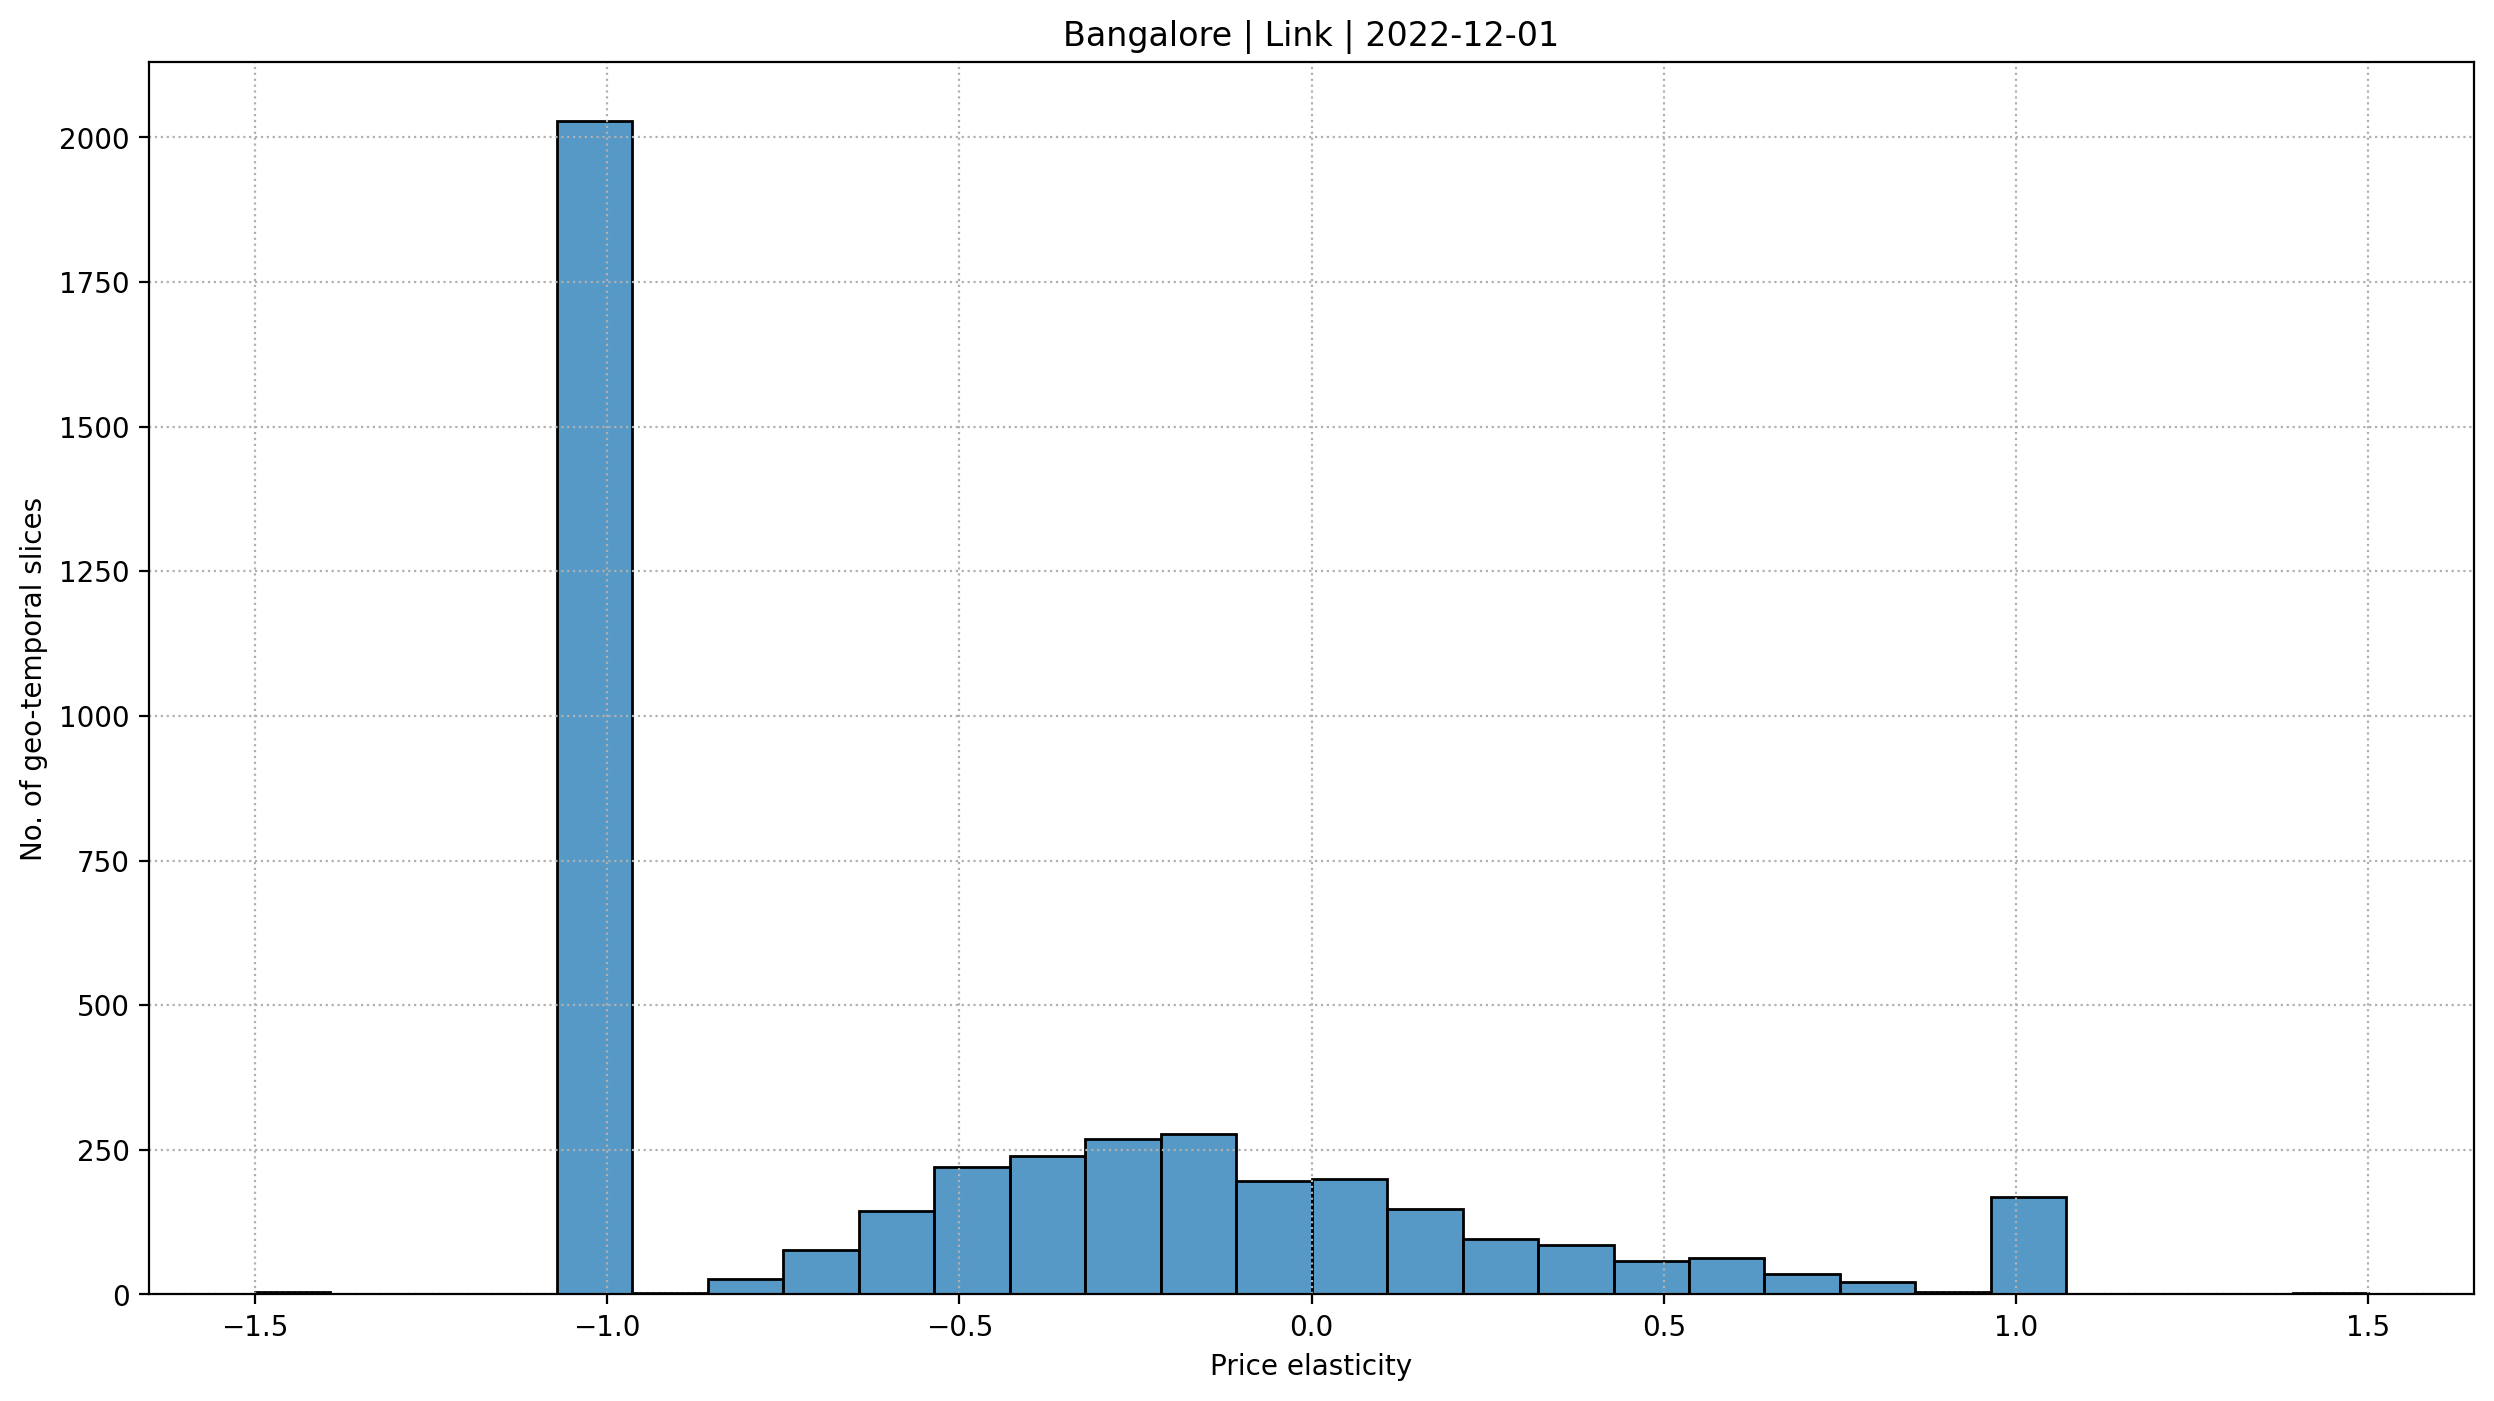

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax = sns.histplot(data=results[(results['price_elasticity'] >= -1.5) & (results['price_elasticity'] <= 1.5)], x='price_elasticity', ax=ax)
ax.grid(linestyle='dotted')
ax.set_xlabel('Price elasticity')
ax.set_ylabel('No. of geo-temporal slices')
ax.set_title('{} | {} | {}'.format(CONFIG_CITY, CONFIG_SERVICE_LEVEL, CONFIG_EXPERIMENT_DATE));

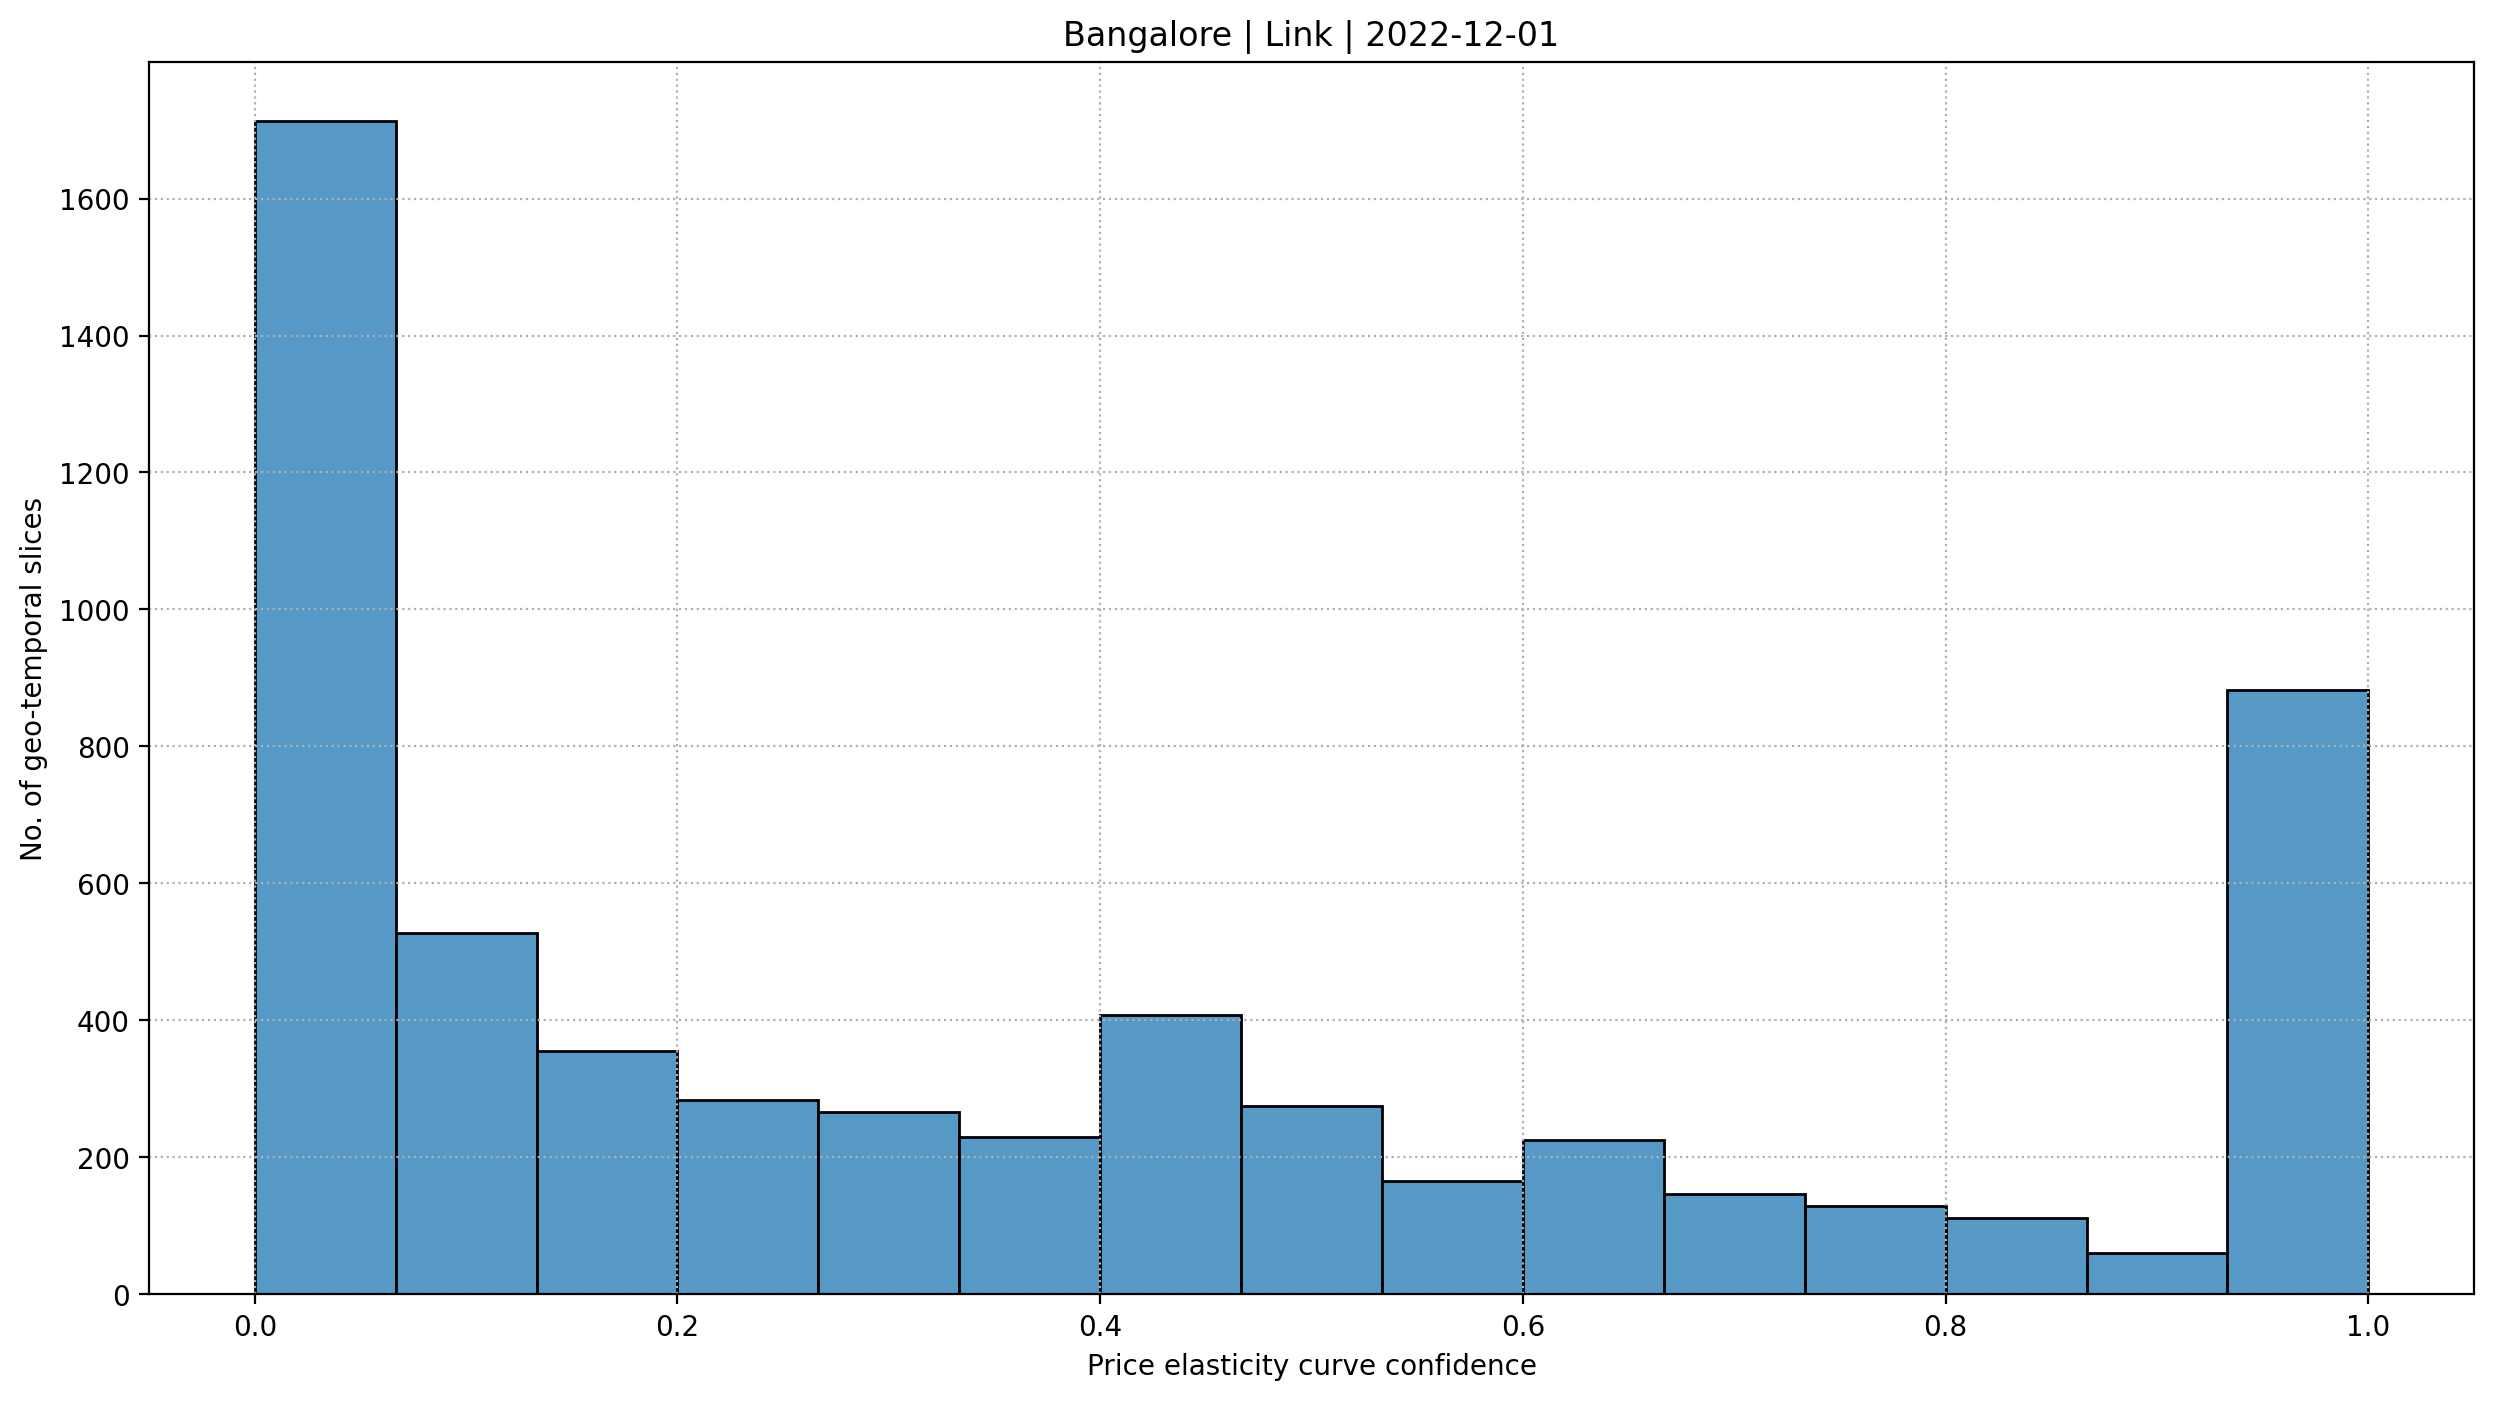

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax = sns.histplot(data=results, x='price_elasticity_curve_confidence', ax=ax)
ax.grid(linestyle='dotted')
ax.set_xlabel('Price elasticity curve confidence')
ax.set_ylabel('No. of geo-temporal slices')
ax.set_title('{} | {} | {}'.format(CONFIG_CITY, CONFIG_SERVICE_LEVEL, CONFIG_EXPERIMENT_DATE));

In [35]:
# View elasticities for some sample geo-temporal slices.
counts = dataset \
    .groupby(['yyyymmdd', 'timebucket', 'city', 'cluster', 'hex']) \
    .agg({'fare_estimates': 'sum'}) \
    .reset_index() \
    .sort_values(by='fare_estimates', ascending=False) \
    .reset_index(drop=True)

sample = counts.iloc[1]

results_subset = results[(results['cluster'] == sample['cluster'])].reset_index(drop=True).copy(deep=True).sort_values(by='price_elasticity', ascending=False)
results_subset.reset_index(drop=True)

,yyyymmdd,timebucket,city,cluster,hex,price_elasticity,price_elasticity_label,price_elasticity_curve_slope,price_elasticity_curve_intercept,price_elasticity_curve_confidence,surge_percentages,fare_estimates,gross_orders,fe2rrs,price_elasticities,price_elasticity_labels
0,20221201,rest_evening,Bangalore,Tavarakere,88618925c3fffff,-0.16,less_elastic,-0.051,18.141,0.053,"[0.0, 10.0, 20.0, 30.0, 40.0, 50.0]","[197, 28, 28, 31, 41, 27]","[40, 3, 6, 6, 6, 4]","[20.3, 10.71, 21.43, 19.35, 14.63, 14.81]","[NaN, -0.31, 1.0, -0.26, -0.97, 0.06]","[""undefined"", ""less_elastic"", ""unitary_elastic..."
1,20221201,rest_evening,Bangalore,Tavarakere,8861892589fffff,-0.24,less_elastic,-0.041,16.050,0.015,"[0.0, 10.0, 20.0, 30.0, 40.0, 50.0]","[273, 42, 30, 63, 28, 59]","[45, 8, 3, 6, 7, 6]","[16.48, 19.05, 10.0, 9.52, 25.0, 10.17]","[NaN, 0.07, -0.93, -0.12, 3.14, -3.79]","[""undefined"", ""less_elastic"", ""less_elastic"", ..."
2,20221201,evening_peak,Bangalore,Tavarakere,88618925c3fffff,-0.26,less_elastic,-0.062,9.206,0.280,"[0.0, 10.0, 20.0, 30.0, 40.0, 50.0]","[1757, 348, 375, 292, 391, 299]","[190, 20, 30, 28, 21, 19]","[10.81, 5.75, 8.0, 9.59, 5.37, 6.35]","[NaN, -0.31, 0.49, 0.45, -1.97, 0.75]","[""undefined"", ""less_elastic"", ""less_elastic"", ..."
3,20221201,evening_peak,Bangalore,Tavarakere,8861892589fffff,-0.31,less_elastic,-0.087,9.229,0.784,"[0.0, 10.0, 20.0, 30.0, 40.0, 50.0]","[2484, 565, 622, 634, 450, 487]","[250, 44, 40, 48, 23, 26]","[10.06, 7.79, 6.43, 7.57, 5.11, 5.34]","[NaN, -0.13, -0.29, 0.41, -1.36, 0.2]","[""undefined"", ""less_elastic"", ""less_elastic"", ..."
4,20221201,morning_peak,Bangalore,Tavarakere,8861892589fffff,-0.35,less_elastic,-0.157,13.234,0.747,"[0.0, 10.0, 20.0, 30.0, 40.0, 50.0]","[881, 198, 174, 156, 196, 173]","[117, 24, 15, 17, 9, 11]","[13.28, 12.12, 8.62, 10.9, 4.59, 6.36]","[NaN, -0.05, -0.51, 0.58, -2.85, 1.45]","[""undefined"", ""less_elastic"", ""less_elastic"", ..."
5,20221201,afternoon,Bangalore,Tavarakere,8861892589fffff,-0.37,less_elastic,-0.102,8.733,0.770,"[0.0, 10.0, 20.0, 30.0, 40.0, 50.0]","[1727, 434, 340, 356, 465, 297]","[150, 37, 23, 13, 25, 12]","[8.69, 8.53, 6.76, 3.65, 5.38, 4.04]","[NaN, -0.01, -0.35, -1.49, 1.34, -1.28]","[""undefined"", ""less_elastic"", ""less_elastic"", ..."
6,20221201,afternoon,Bangalore,Tavarakere,88618925c3fffff,-0.39,less_elastic,-0.162,13.486,0.787,"[0.0, 10.0, 20.0, 30.0, 40.0, 50.0]","[781, 217, 190, 190, 222, 162]","[100, 31, 17, 13, 18, 9]","[12.8, 14.29, 8.95, 6.84, 8.11, 5.56]","[NaN, 0.06, -0.69, -0.67, 0.59, -1.68]","[""undefined"", ""less_elastic"", ""less_elastic"", ..."
7,20221201,morning_peak,Bangalore,Tavarakere,88618925c3fffff,-0.40,less_elastic,-0.146,15.817,0.784,"[0.0, 10.0, 20.0, 30.0, 40.0, 50.0]","[2263, 398, 443, 430, 414, 461]","[351, 58, 55, 48, 52, 31]","[15.51, 14.57, 12.42, 11.16, 12.56, 6.72]","[NaN, -0.03, -0.24, -0.27, 0.41, -2.73]","[""undefined"", ""less_elastic"", ""less_elastic"", ..."
8,20221201,rest_morning,Bangalore,Tavarakere,88618925c3fffff,-0.45,less_elastic,-0.220,15.554,0.731,"[0.0, 10.0, 20.0, 30.0, 40.0, 50.0]","[460, 63, 96, 76, 66, 75]","[65, 8, 14, 8, 2, 4]","[14.13, 12.7, 14.58, 10.53, 3.03, 5.33]","[NaN, -0.05, 0.21, -0.81, -3.87, 2.48]","[""undefined"", ""less_elastic"", ""less_elastic"", ..."
9,20221201,rest_morning,Bangalore,Tavarakere,8861892589fffff,-1.00,unitary_elastic,-0.272,15.606,0.720,"[0.0, 10.0, 20.0, 30.0, 40.0, 50.0]","[283, 75, 44, 39, 59, 46]","[42, 7, 7, 3, 3, 0]","[14.84, 9.33, 15.91, 7.69, 5.08, 0.0]","[NaN, -0.23, 0.78, -1.74, -1.43, -9.0]","[""undefined"", ""less_elastic"", ""less_elastic"", ..."


In [36]:
# What are the datatypes of the columns.
results.dtypes

yyyymmdd                               int64
timebucket                            object
city                                  object
cluster                               object
hex                                   object
price_elasticity                     float64
price_elasticity_label                object
price_elasticity_curve_slope         float64
price_elasticity_curve_intercept     float64
price_elasticity_curve_confidence    float64
surge_percentages                     object
fare_estimates                        object
gross_orders                          object
fe2rrs                                object
price_elasticities                    object
price_elasticity_labels               object
dtype: object

In [37]:
# Write results to a csv file.
results.to_csv('/Users/rapido/local-datasets/affluence/processed/price_elasticity_hex_timebucket_{}_{}_{}.csv'.format(CONFIG_CITY, CONFIG_SERVICE_LEVEL, CONFIG_EXPERIMENT_DATE), index=False)

In [38]:
results

,yyyymmdd,timebucket,city,cluster,hex,price_elasticity,price_elasticity_label,price_elasticity_curve_slope,price_elasticity_curve_intercept,price_elasticity_curve_confidence,surge_percentages,fare_estimates,gross_orders,fe2rrs,price_elasticities,price_elasticity_labels
0,20221201,evening_peak,Bangalore,St Johns Signal,88618925c7fffff,-0.42,less_elastic,-0.087,10.238,0.477,"[0.0, 10.0, 20.0, 30.0, 40.0, 50.0]","[3736, 719, 729, 653, 802, 588]","[391, 70, 45, 56, 73, 25]","[10.47, 9.74, 6.17, 8.58, 9.1, 4.25]","[NaN, -0.04, -0.67, 0.82, 0.21, -3.27]","[""undefined"", ""less_elastic"", ""less_elastic"", ..."
1,20221201,evening_peak,Bangalore,Tavarakere,8861892589fffff,-0.31,less_elastic,-0.087,9.229,0.784,"[0.0, 10.0, 20.0, 30.0, 40.0, 50.0]","[2484, 565, 622, 634, 450, 487]","[250, 44, 40, 48, 23, 26]","[10.06, 7.79, 6.43, 7.57, 5.11, 5.34]","[NaN, -0.13, -0.29, 0.41, -1.36, 0.2]","[""undefined"", ""less_elastic"", ""less_elastic"", ..."
2,20221201,morning_peak,Bangalore,Tavarakere,88618925c3fffff,-0.40,less_elastic,-0.146,15.817,0.784,"[0.0, 10.0, 20.0, 30.0, 40.0, 50.0]","[2263, 398, 443, 430, 414, 461]","[351, 58, 55, 48, 52, 31]","[15.51, 14.57, 12.42, 11.16, 12.56, 6.72]","[NaN, -0.03, -0.24, -0.27, 0.41, -2.73]","[""undefined"", ""less_elastic"", ""less_elastic"", ..."
3,20221201,evening_peak,Bangalore,Hsr,8861892421fffff,-0.43,less_elastic,-0.136,11.677,0.814,"[0.0, 10.0, 20.0, 30.0, 40.0, 50.0]","[2032, 407, 419, 349, 439, 411]","[260, 40, 29, 31, 27, 21]","[12.8, 9.83, 6.92, 8.88, 6.15, 5.11]","[NaN, -0.13, -0.52, 0.62, -1.27, -0.83]","[""undefined"", ""less_elastic"", ""less_elastic"", ..."
4,20221201,morning_peak,Bangalore,BTM,88618925cbfffff,-0.09,less_elastic,-0.079,15.065,0.221,"[0.0, 10.0, 20.0, 30.0, 40.0, 50.0]","[1948, 349, 268, 341, 334, 409]","[337, 47, 30, 48, 27, 59]","[17.3, 13.47, 11.19, 14.08, 8.08, 14.43]","[NaN, -0.12, -0.28, 0.57, -1.9, 2.54]","[""undefined"", ""less_elastic"", ""less_elastic"", ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5772,20221201,rest_evening,Bangalore,Kengeri,8860145ae9fffff,NaN,undefined,0.000,0.000,0.000,[0.0],[1],[0],[0.0],[NaN],"[""undefined""]"
5773,20221201,afternoon,Bangalore,Horamavu,8861892c63fffff,NaN,undefined,0.000,0.000,0.000,[20.0],[1],[0],[0.0],[NaN],"[""undefined""]"
5774,20221201,rest_evening,Bangalore,BLR_Hoskote,8861892a97fffff,NaN,undefined,0.000,0.000,0.000,[40.0],[1],[0],[0.0],[NaN],"[""undefined""]"
5775,20221201,rest_evening,Bangalore,Kathriguppe,8860145a57fffff,NaN,undefined,0.000,0.000,0.000,[10.0],[1],[0],[0.0],[NaN],"[""undefined""]"


In [39]:
results['cluster'].unique()

array(['St Johns Signal', 'Tavarakere', 'Hsr', 'BTM', 'Trinity',
       'Bellandur', 'BTM Second Stage', 'Ejipura', 'Kadubeesanahalli',
       'Domlur', 'RMZ Ecospace - Bellandur', 'Richmond Town',
       'BLR_Indiranagar', 'Koramangala 2', 'BLR_Ashok Nagar',
       'Munnekollal', 'HSR 2 ', 'Brookefield', 'Venkatapura',
       'Koramangala - ST Bed', 'Koramangala', 'ShivajiNagar - Bangalore',
       'Marathahalli', 'Garvebhavipalya', 'Majestic', 'Jayanagar',
       'Whitefield', 'Bilekahalli', 'Victoria layout', 'Adugodi',
       'NIMHANS', 'Indiranagar Empire', 'Doddanakundi',
       'JP Nagar Dollars Colony', 'HAL', 'Jeevanbheemanagar',
       'Electronic City', 'JP Nagar 5th Phase', 'Sarjapur Road',
       'Arekere', 'Sampagni Rama Nagar', 'Kalasipalyam', 'Banashankri',
       'Sudhama Nagar', 'Hosapalya', 'Columbia Asia Whitefield',
       'Nagavara', 'Wilson Garden', 'Basavanagudi', 'Bommanahali',
       'J P nagar', 'K R Puram', 'Neelasandra', 'Hulimavu', 'Begur',
       'C V Ram

In [40]:
results['hex'].nunique()

1306

In [41]:
results[results['cluster'].isin(['Yeshwantpur'])] 

,yyyymmdd,timebucket,city,cluster,hex,price_elasticity,price_elasticity_label,price_elasticity_curve_slope,price_elasticity_curve_intercept,price_elasticity_curve_confidence,surge_percentages,fare_estimates,gross_orders,fe2rrs,price_elasticities,price_elasticity_labels


In [42]:
"""
    if pd.isna(ep):  return 'undefined'
    if ep == 0.0:    return 'perfectly_inelastic'
    elif ep == 1.0:  return 'unitary_elastic'
    elif ep > 1.0:   return 'highly_elastic'
    elif ep < 1.0:   return 'less_elastic'
    else:            return 'error'
"""

"\n    if pd.isna(ep):  return 'undefined'\n    if ep == 0.0:    return 'perfectly_inelastic'\n    elif ep == 1.0:  return 'unitary_elastic'\n    elif ep > 1.0:   return 'highly_elastic'\n    elif ep < 1.0:   return 'less_elastic'\n    else:            return 'error'\n"